## Notebook to combine drifts
(to be implemented in python module at later point)

In [21]:
# imports
from utils import helpers, constants
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# config
change_point_detector = 'emd'

# load data dictionary
data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)

In [46]:
window_sizes = [100, 200, 300, 400, 500, 600]

# Load all change points into a consistent dictionary of DataFrames
change_points_dict = {}

for dataset in data_dictionary:
    records = []
    for window_size in window_sizes:
        results_path = f'results/drift_detection/{dataset}/results_{dataset}_{change_point_detector}{window_size}.csv'
        if os.path.exists(results_path):
            results_df = pd.read_csv(results_path)
            for _, row in results_df.iterrows():
                if row.get('calc_drift_id') == 'na':
                    break
                records.append({
                    'dataset': dataset,
                    'window_size': window_size,
                    'start_index': row.get('calc_change_index'),
                    'start_time': row.get('calc_change_moment'),
                    'change_type': row.get('calc_change_type'),
                })
    change_points_dict[dataset] = pd.DataFrame(records)

# Deduplication function using alpha-scaled window size
def deduplicate_change_points_by_window(dataset_df, alpha=1.0):
    if dataset_df.empty:
        return dataset_df

    # Sort by window size descending, then start index ascending
    dataset_df = dataset_df.sort_values(by=["window_size", "start_index"], ascending=[False, True]).reset_index(drop=True)

    # Initialize support count and unify change type
    dataset_df["support_count"] = 1
    dataset_df["change_type"] = "any"

    # Set to keep track of rows marked for removal
    to_remove = set()

    # Step 1: iterate over each change point from largest window size to smallest
    for idx1, cp1 in dataset_df.iterrows():
        if idx1 in to_remove:
            continue  # skip if already removed in a previous match

        ws1 = cp1['window_size']           # current window size
        si1 = cp1['start_index']           # current start index
        threshold = ws1 * alpha            # calculate matching threshold

        # Step 2: find all change points from smaller window sizes
        smaller_df = dataset_df[(dataset_df['window_size'] < ws1)].copy()

        # Step 3: try to match cp1 to any smaller-window change point within threshold
        for idx2, cp2 in smaller_df.iterrows():
            if idx2 in to_remove:
                continue  # skip if already matched

            si2 = cp2['start_index']

            if abs(si2 - si1) <= threshold:
                # A match is found — increment support count of the smaller window point
                dataset_df.at[idx2, 'support_count'] += 1

                # Mark the larger-window point for removal
                to_remove.add(idx1)
                break  # move to next outer loop point

    # Drop marked rows and return clean index
    return dataset_df.drop(index=to_remove).reset_index(drop=True)


# Deduplicate all datasets
deduplicated_dict = {
    dataset: deduplicate_change_points_by_window(df, alpha=1.0)
    for dataset, df in change_points_dict.items()
}

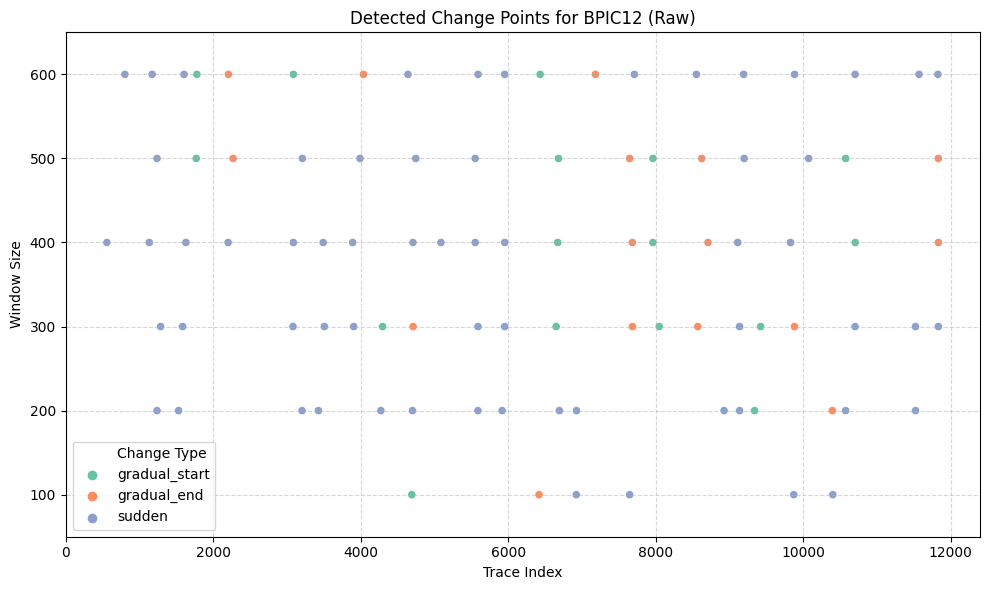

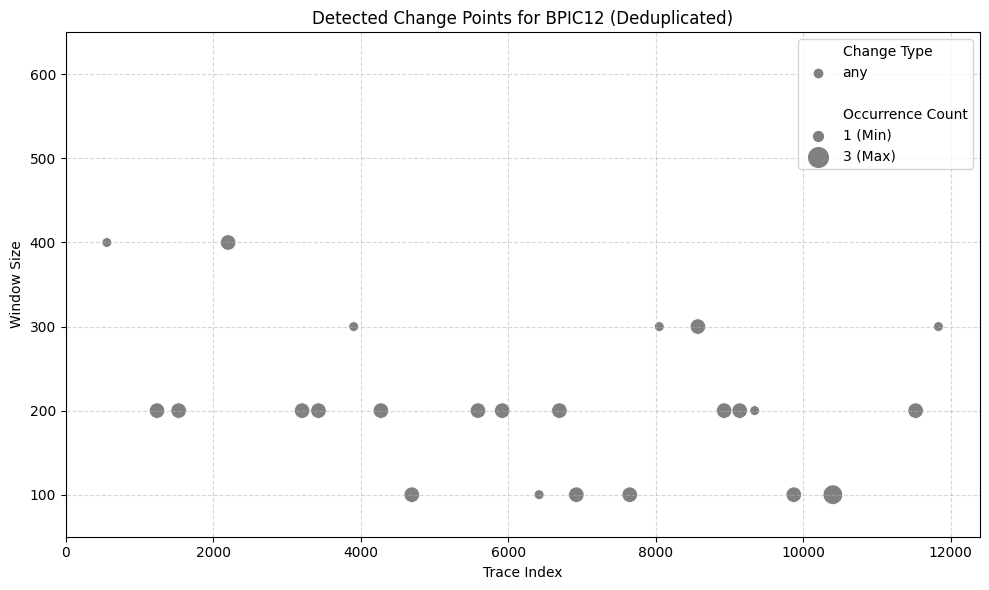

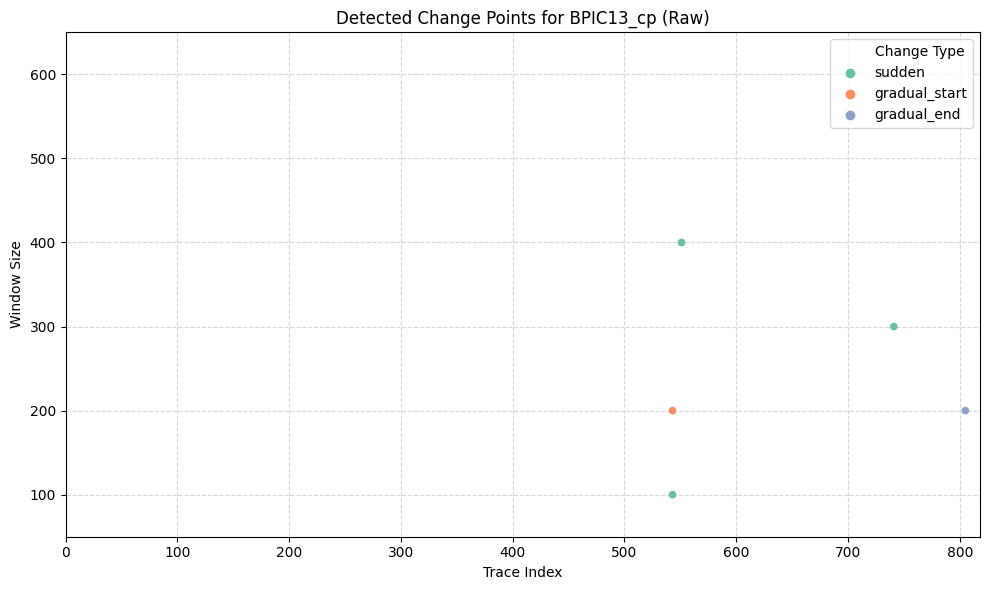

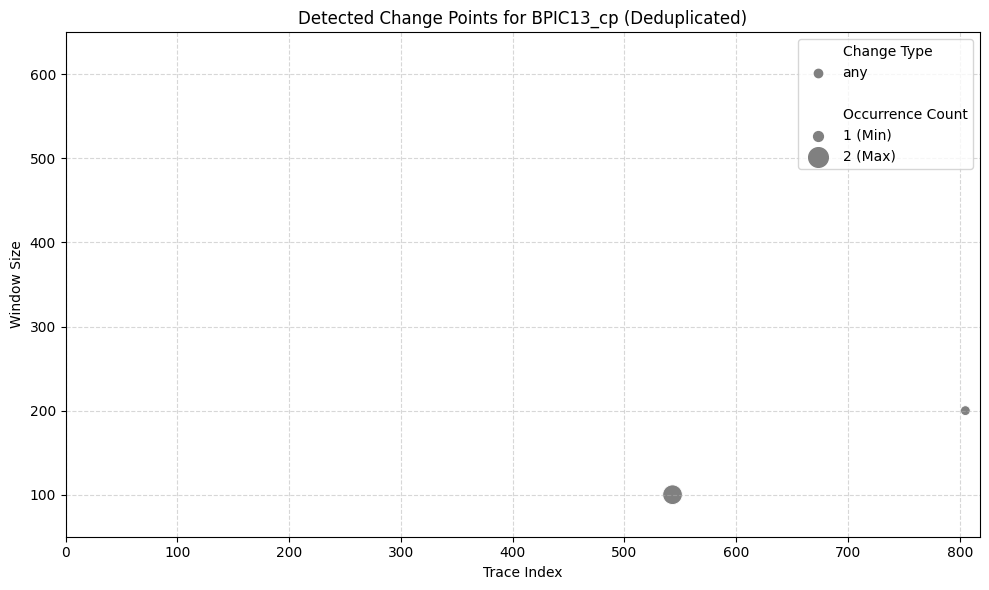

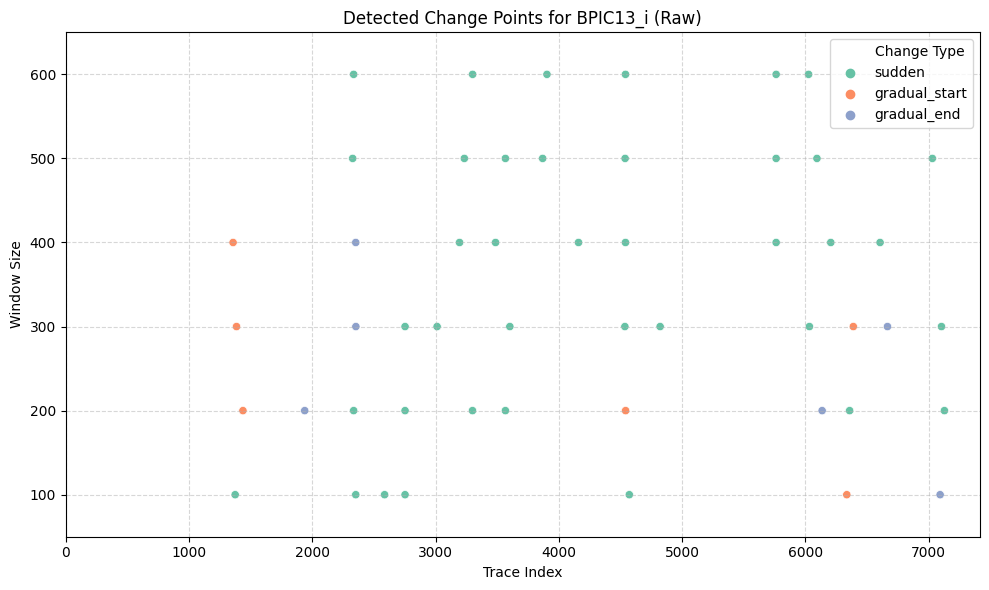

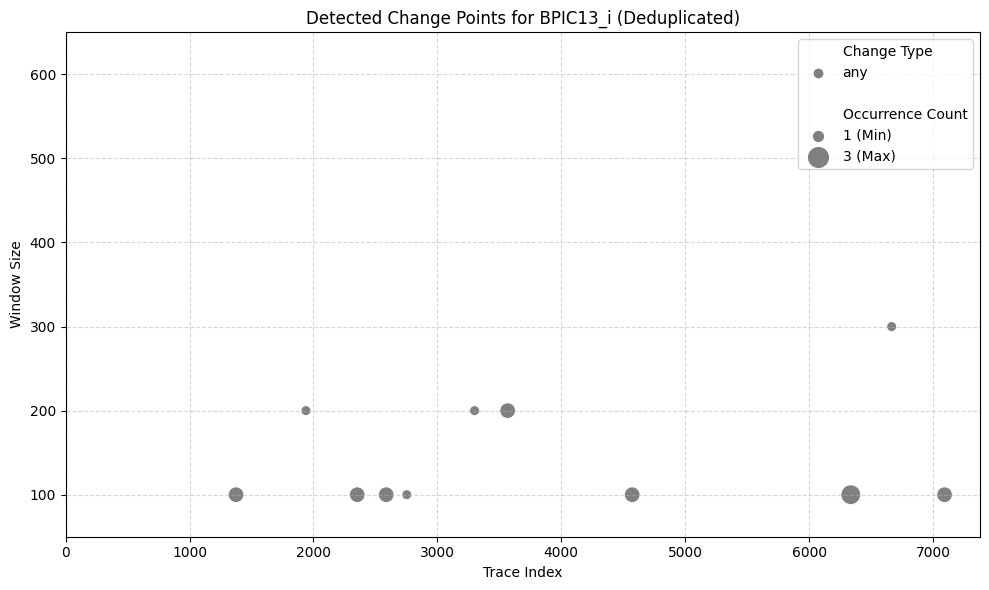

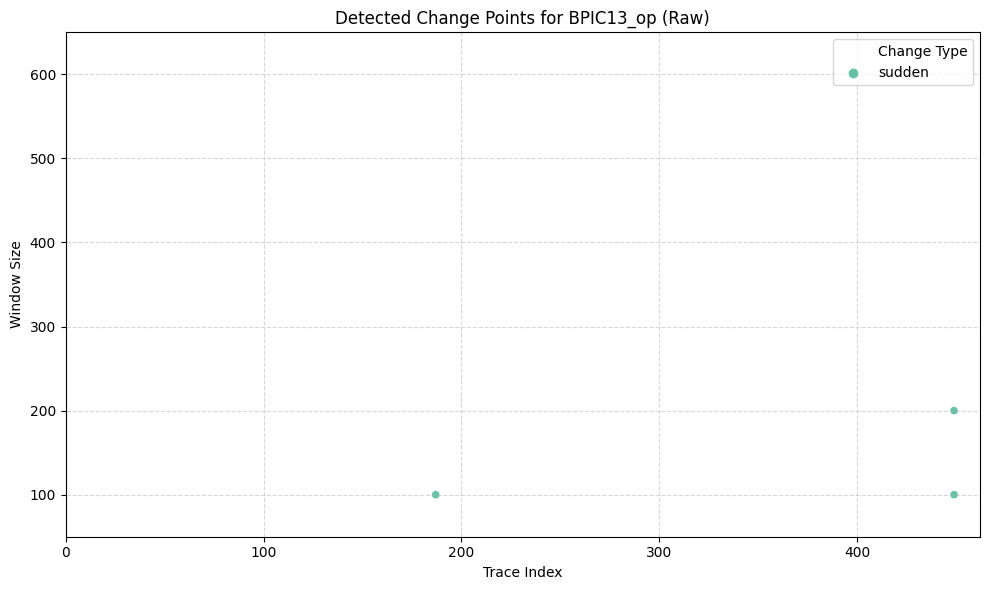

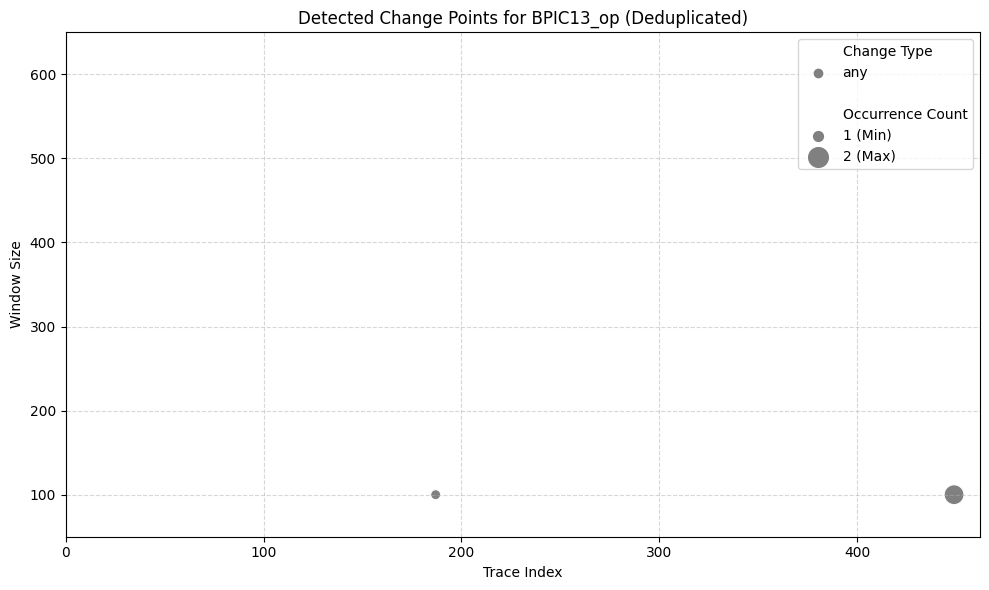

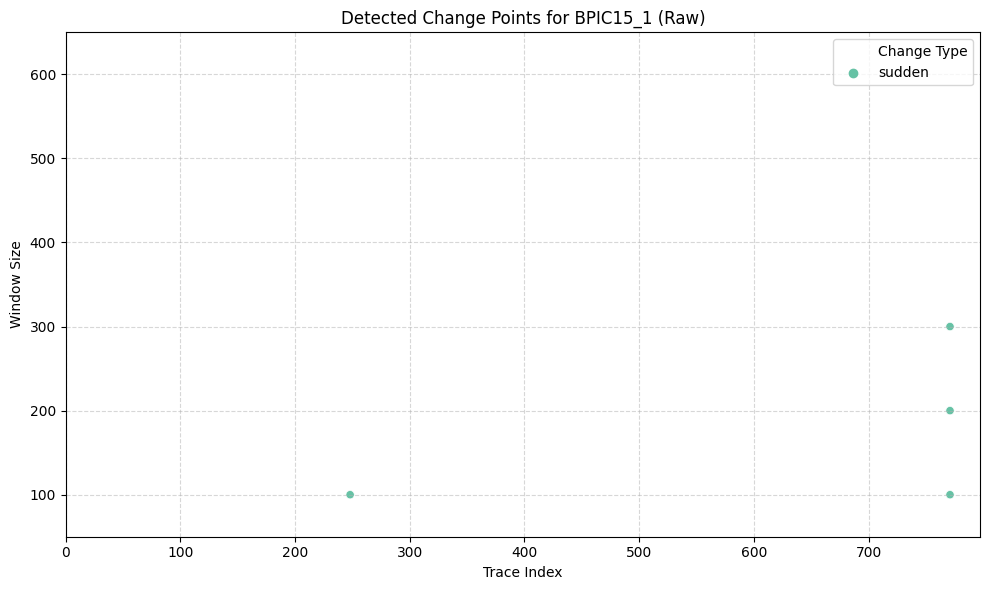

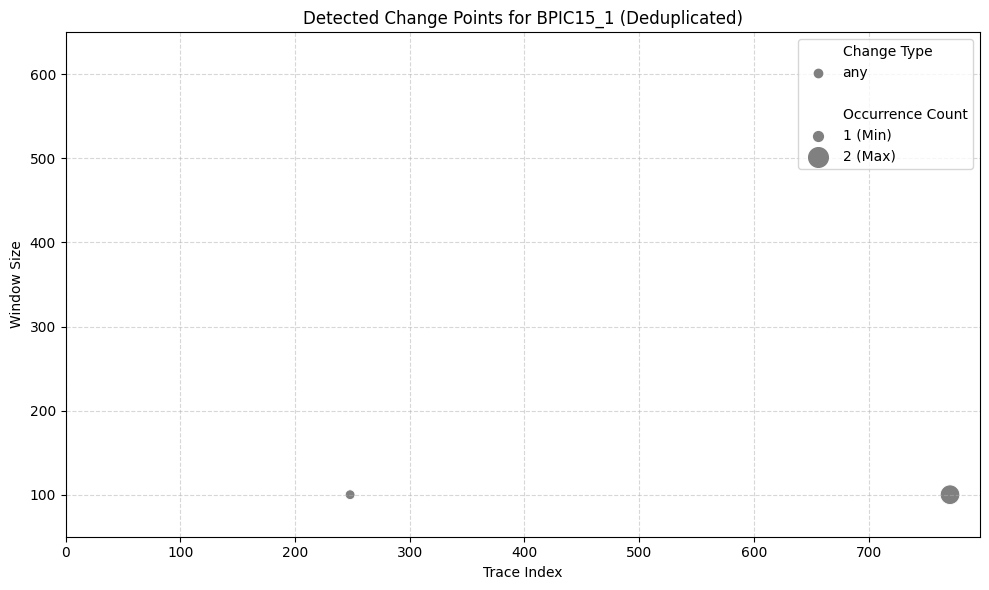

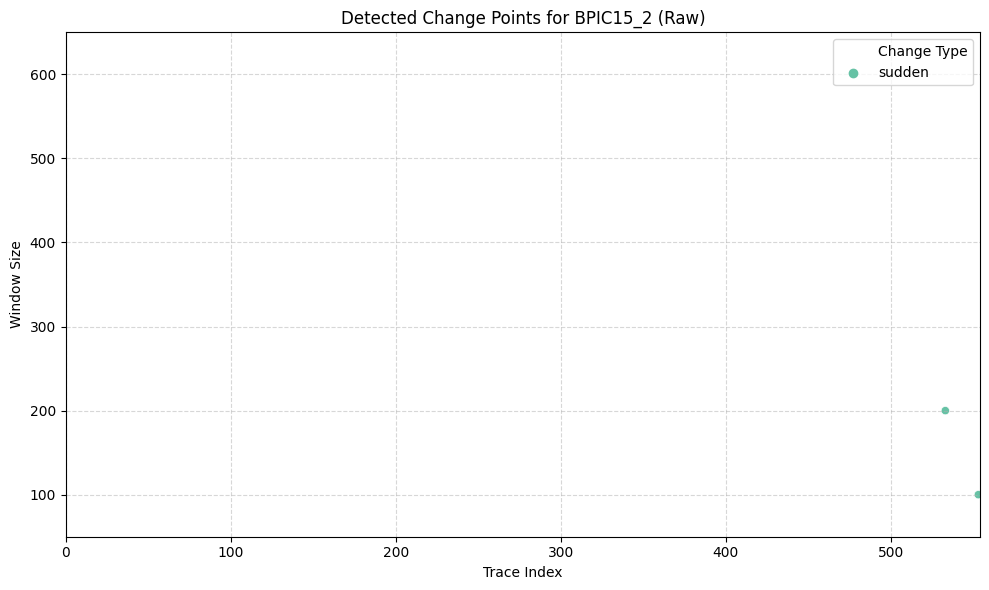

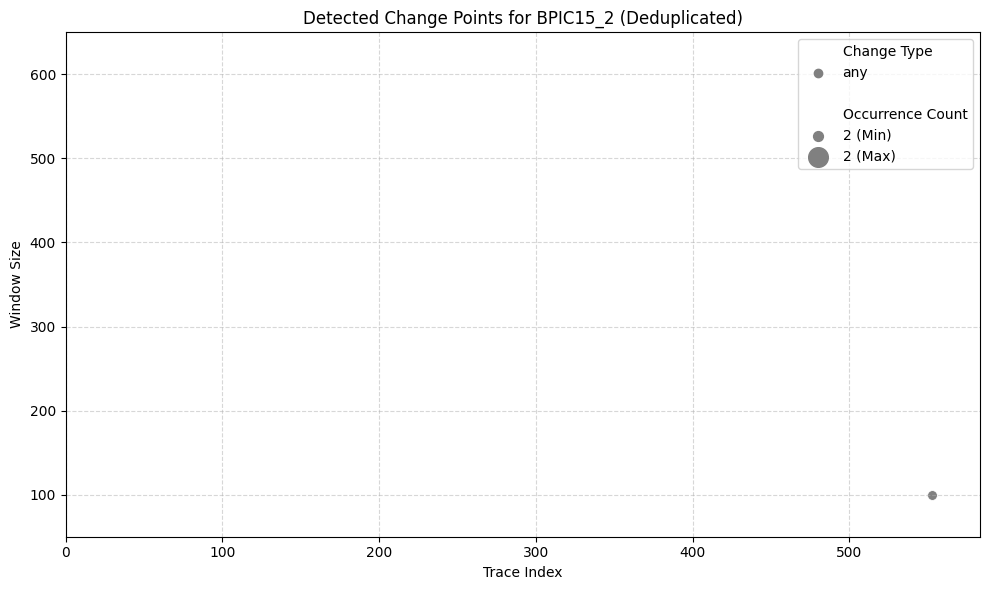

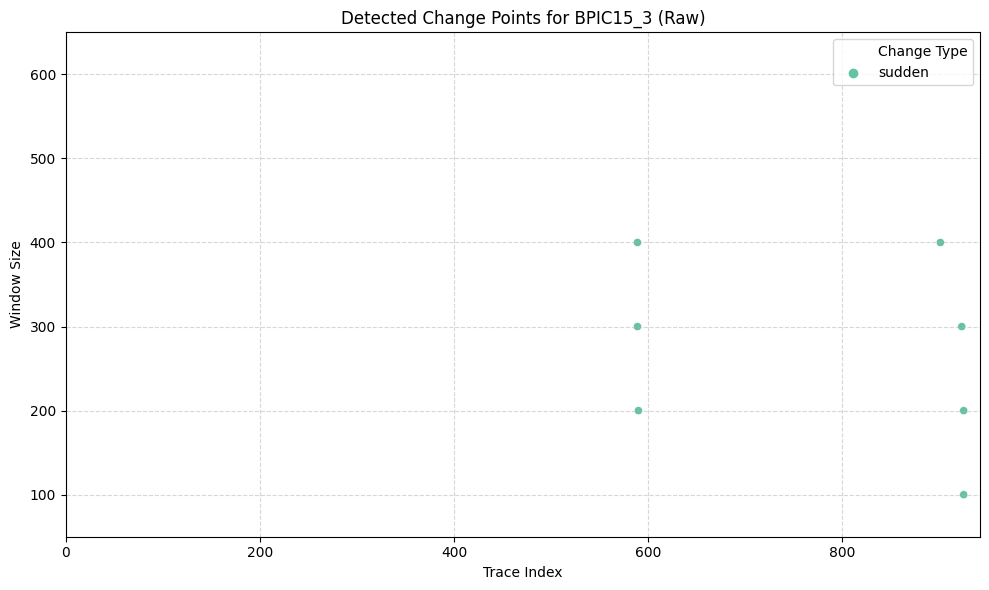

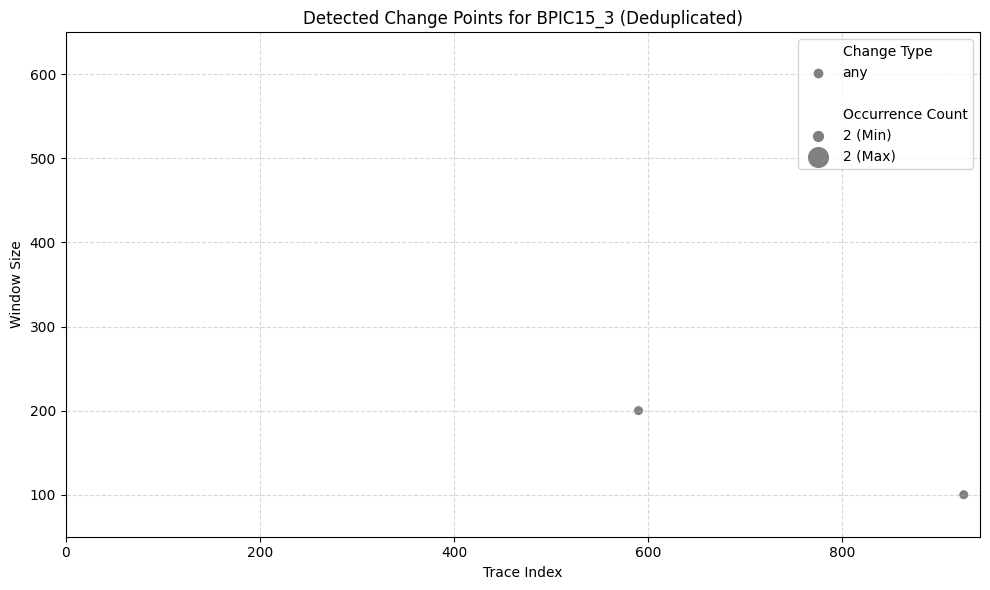

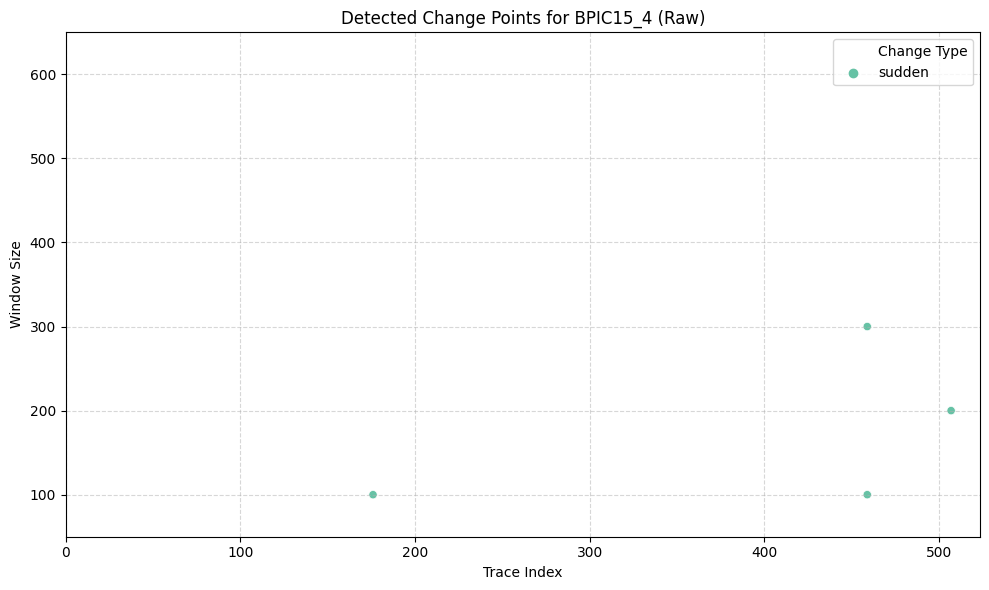

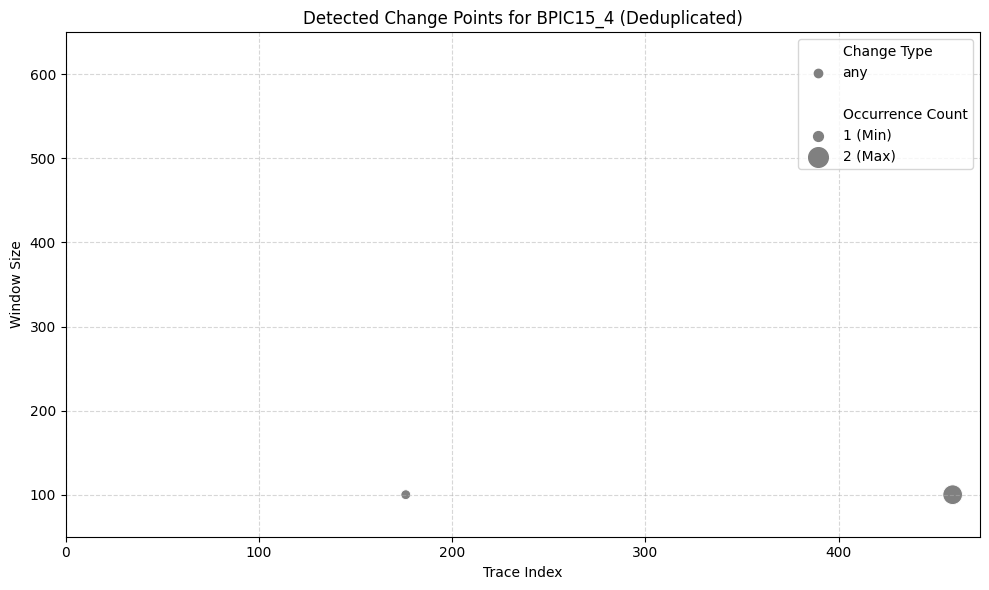

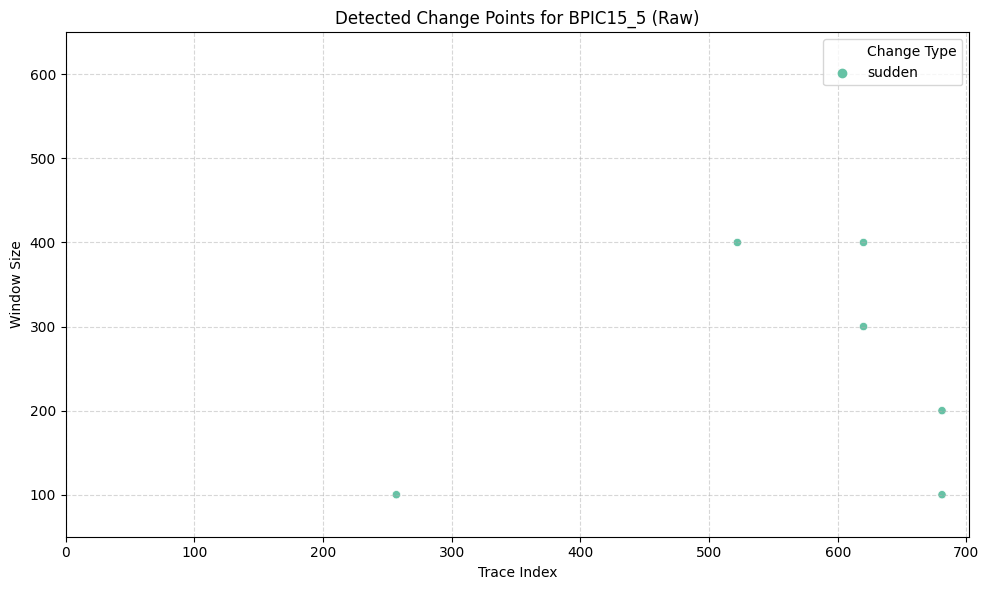

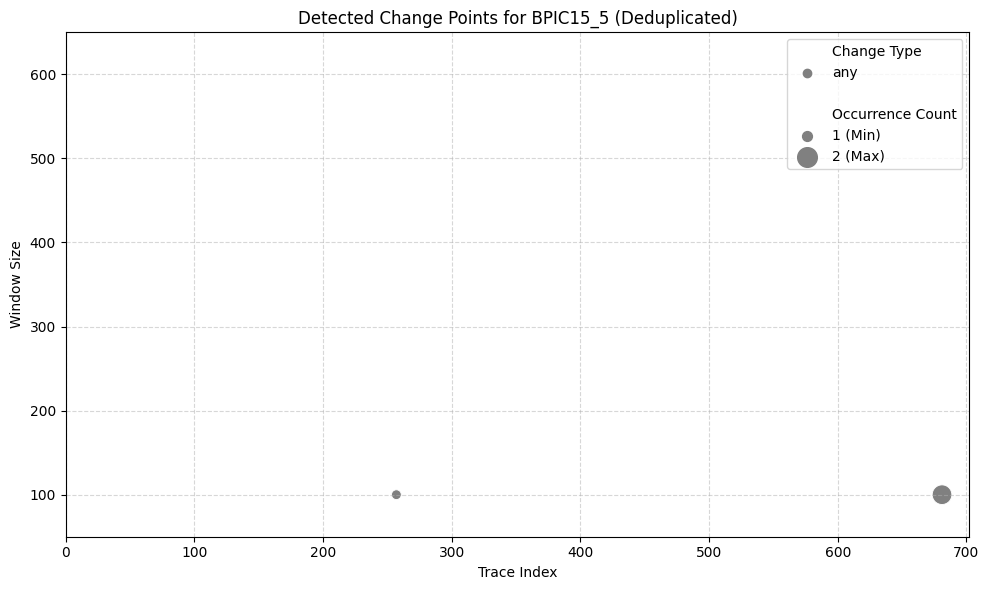

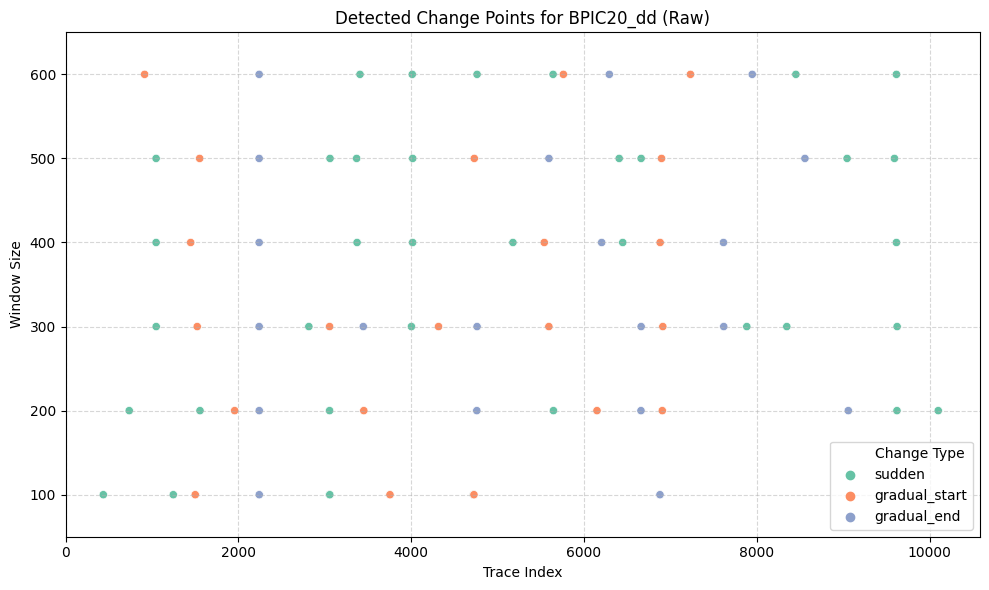

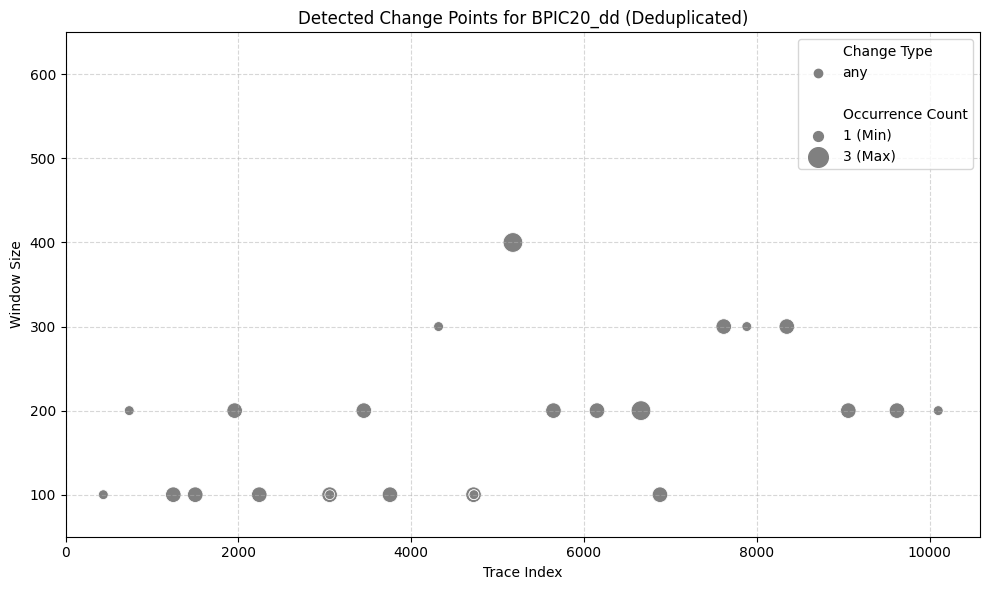

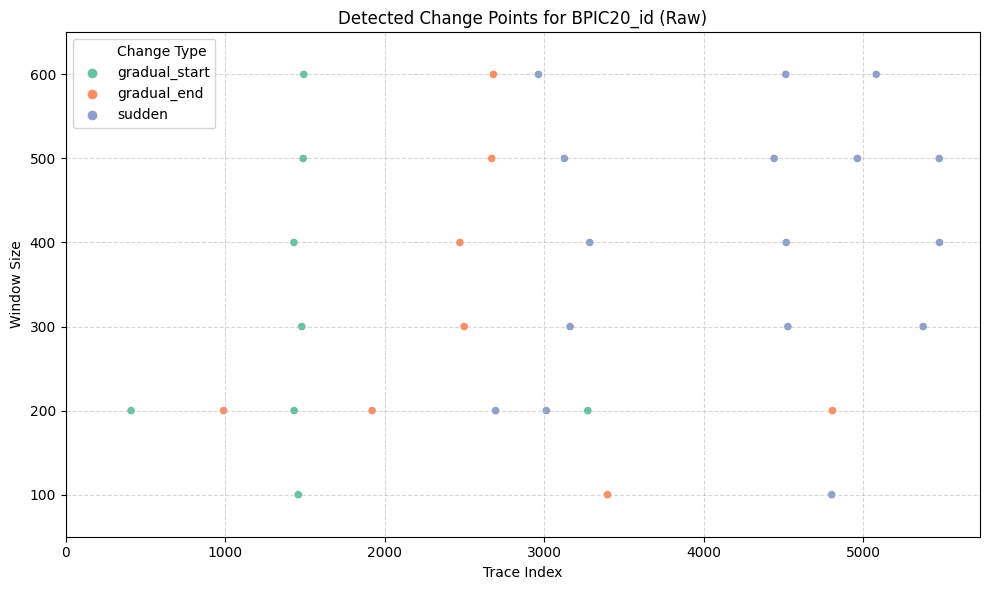

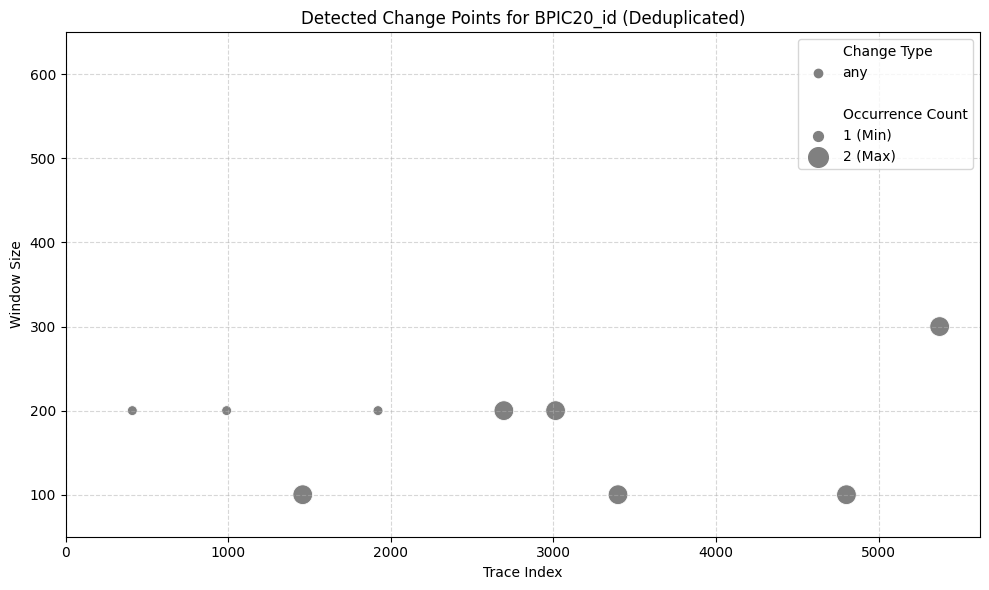

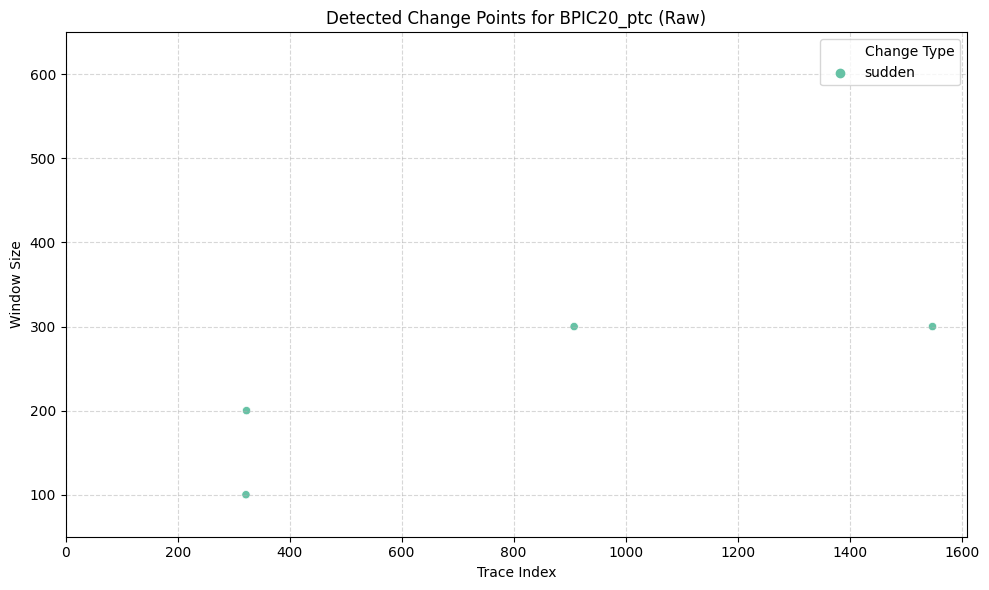

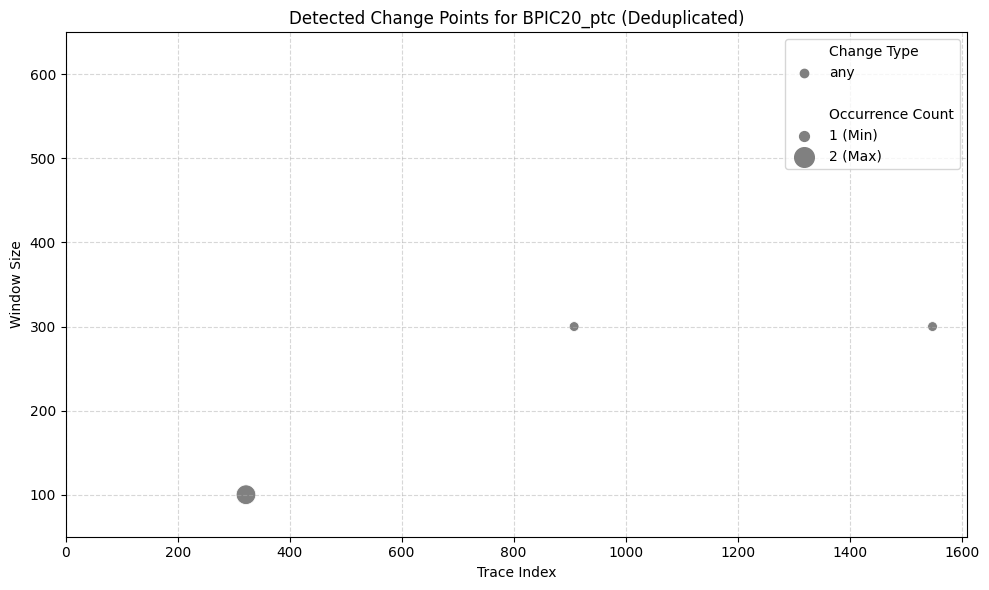

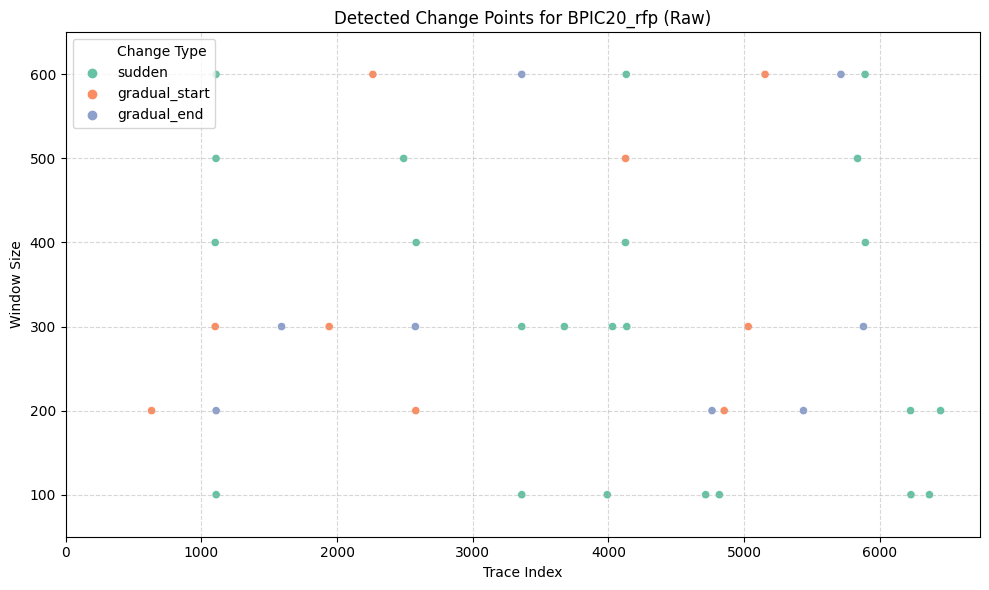

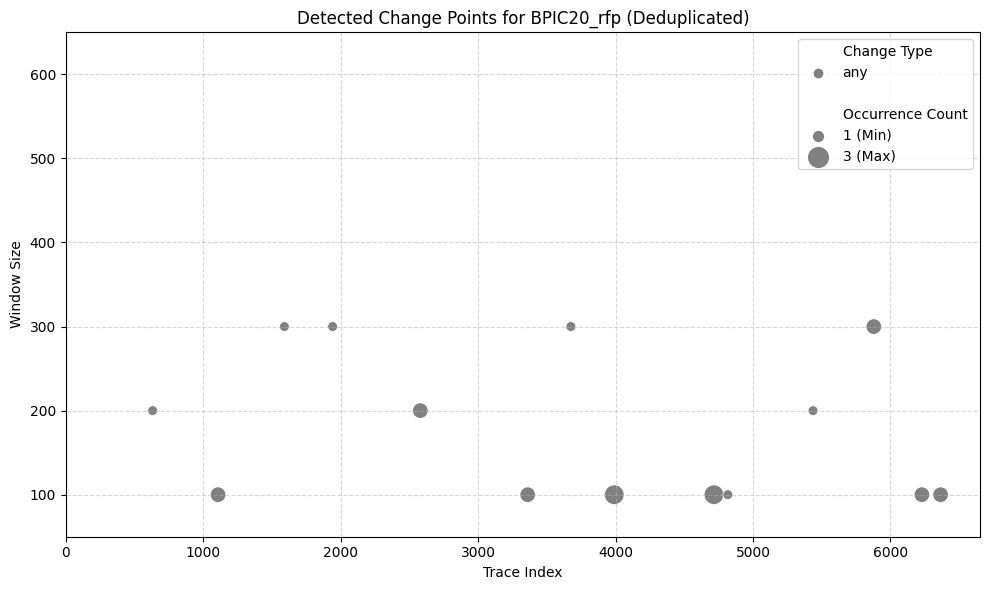

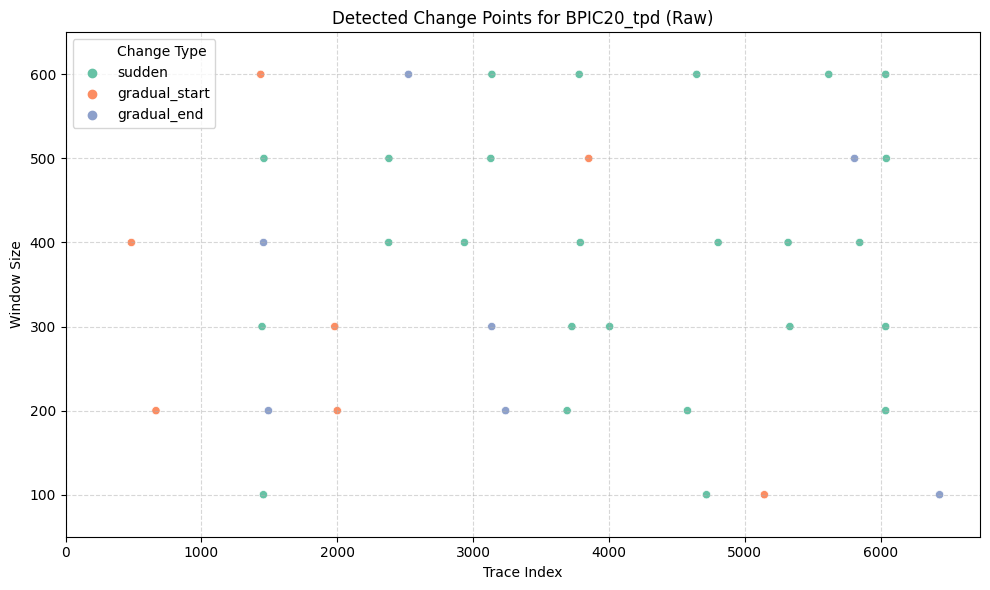

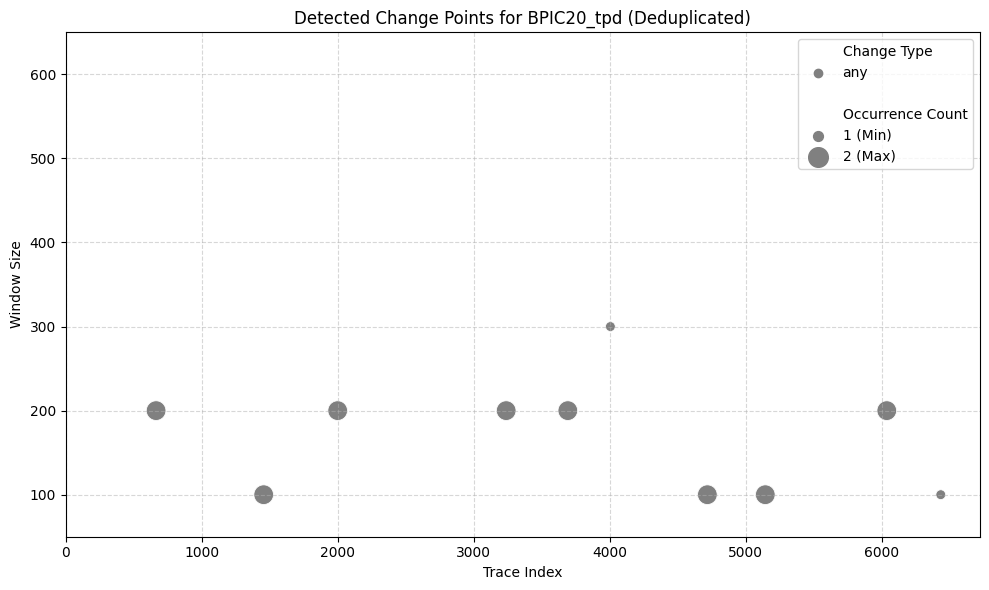

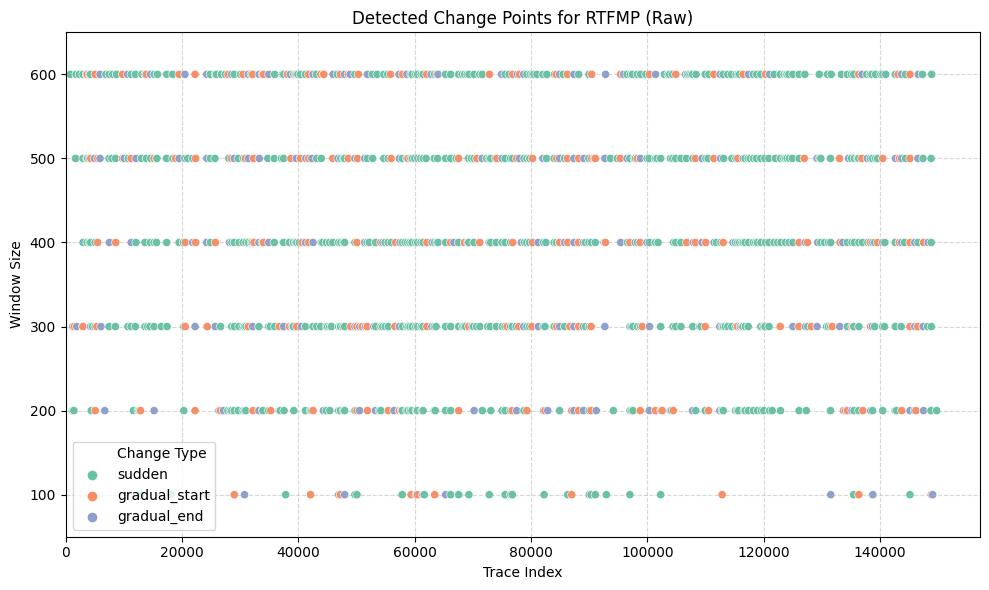

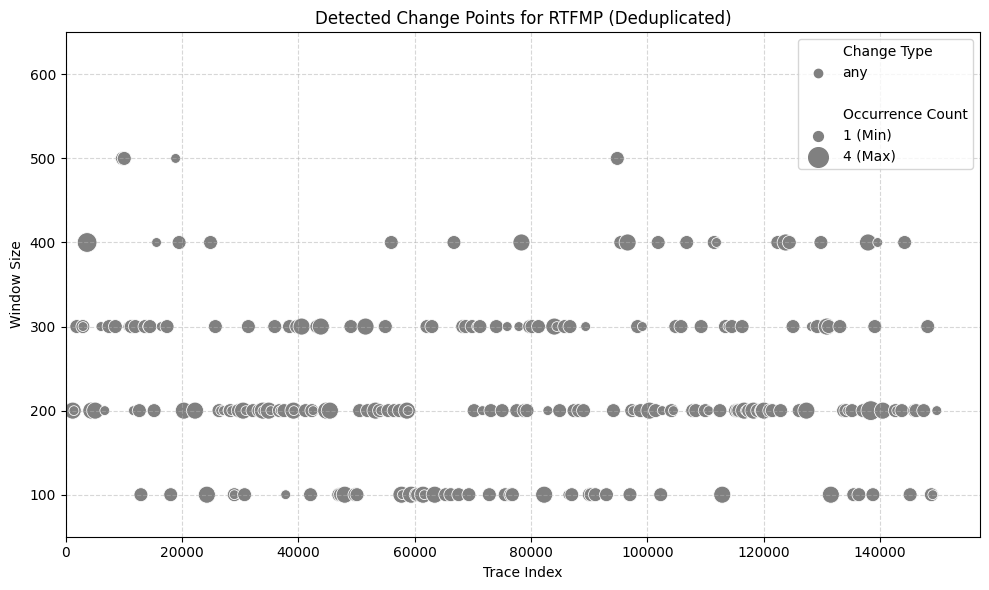

In [54]:
def plot_change_points(dataset, dataset_df, window_sizes, title_suffix=""):
    import matplotlib.patches as mpatches

    if dataset_df.empty:
        return

    plt.figure(figsize=(10, 6))

    hue_column = "change_type" if "change_type" in dataset_df.columns else "change_type"

    # Define color palette, make 'any' gray if present
    if "any" in dataset_df[hue_column].unique():
        unique_types = dataset_df[hue_column].unique()
        palette = {typ: ("gray" if typ == "any" else col) for typ, col in zip(unique_types, sns.color_palette("Set2", len(unique_types)))}
    else:
        palette = "Set2"

    # Compute size if available
    use_size = "support_count" in dataset_df.columns
    if use_size:
        min_size, max_size = 50, 200
        dataset_df["point_size"] = dataset_df["support_count"]
        dataset_df["point_size"] = np.interp(dataset_df["point_size"], [1, max(dataset_df["point_size"])], [min_size, max_size])
        scatter = sns.scatterplot(
            data=dataset_df,
            x="start_index",
            y="window_size",
            hue=hue_column,
            size="point_size",
            sizes=(min_size, max_size),
            palette=palette,
            legend="full"
        )
    else:
        scatter = sns.scatterplot(
            data=dataset_df,
            x="start_index",
            y="window_size",
            hue=hue_column,
            palette=palette,
            legend="full"
        )

    plt.title(f"Detected Change Points for {dataset} {title_suffix}")
    plt.xlabel("Trace Index")
    plt.ylabel("Window Size")
    plt.yticks(sorted(window_sizes))
    plt.xlim(left=0)
    plt.ylim(top=max(window_sizes)+50, bottom=min(window_sizes)-50)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Tidy legend with section headers using proxy artists
    handles, labels = scatter.get_legend_handles_labels()
    new_handles = []
    new_labels = []

    # Section: Change Type
    type_handles = []
    type_labels = []

    for h, l in zip(handles, labels):
        if l in dataset_df[hue_column].unique():
            type_handles.append(h)
            type_labels.append(l)

    if type_handles:
        new_handles.append(mpatches.Patch(color='none', label='Change Type'))
        new_labels.append('Change Type')
        new_handles.extend(type_handles)
        new_labels.extend(type_labels)

    # Blank space between sections
    if use_size:
        new_handles.append(mpatches.Patch(color='none', label=''))
        new_labels.append('')

        # Section: Occurrence Count (min/max only)
        min_count = int(dataset_df['support_count'].min())
        max_count = int(dataset_df['support_count'].max())
        min_patch = plt.scatter([], [], s=min_size, color='gray', label=f"{min_count} (Min)")
        max_patch = plt.scatter([], [], s=max_size, color='gray', label=f"{max_count} (Max)")
        new_handles.append(mpatches.Patch(color='none', label='Occurrence Count'))
        new_labels.append('Occurrence Count')
        new_handles.extend([min_patch, max_patch])
        new_labels.extend([f"{min_count} (Min)", f"{max_count} (Max)"])

    plt.legend(new_handles, new_labels, title=None, frameon=True)
    plt.tight_layout()
    plt.show()

# Plot original and deduplicated points
for dataset, df in change_points_dict.items():
    plot_change_points(dataset, change_points_dict[dataset], window_sizes, title_suffix="(Raw)")
    plot_change_points(dataset, deduplicated_dict[dataset], window_sizes, title_suffix="(Deduplicated)")